In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
import pandas as pd

sys.path.append('../../../param_search')
import param_search as ps

ps.set_verbose(False)
ps.set_backend('slurm')

In [31]:
#csv_path = '2025-11-02_selected.csv'
#csv_path = '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-24_preprocessed.csv'
csv_path = '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-26_preprocessed.csv'
sel = pd.read_csv(csv_path)
sel

,Unnamed: 0,subject,metadata.category.set,metadata.category.len,metadata.category.set_f,metadata.category.len_f,metadata.category.valid,metadata.category.reasons,metadata.unit.value,metadata.unit.valid,...,artifacts.valid,artifacts.reasons,valid,reasons,artifacts.scene.exc,paths.source_mask.exc,source_path,job_name,job_id,dims_error
0,0,wss.100f39dce7690f59efb94709f30ce0d2,"{'Recliner', 'Chair'}",2,"{'Recliner', 'Chair'}",2,True,(),0.012947,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,7.294375e-08
1,1,wss.101354f9d8dede686f7b08d9de913afe,"{'Speaker', '_Attributes'}",2,{'Speaker'},1,True,(),0.013620,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,1.319075e-08
2,2,wss.1029fd5d71a06ea32ea98d69e91ba870,{'ChestOfDrawers'},1,{'ChestOfDrawers'},1,True,(),0.019631,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,8.319422e-08
3,3,wss.102a6b7809f4e51813842bc8ef6fe18,"{'Desktop', 'Computer'}",2,"{'Desktop', 'Computer'}",2,True,(),0.025252,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,1.077898e-07
4,4,wss.107637b6bdf8129d4904d89e9169817b,{'Couch'},1,{'Couch'},1,True,(),0.022625,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,7.520307e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,1108,wss.d2014ddbb4e91d7ecb1a776b5576b46b,{'Couch'},1,{'Couch'},1,True,(),0.024101,True,...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
941,1109,wss.d37fc7d310906d81350844aa00c7f347,{'TrashBin'},1,{'TrashBin'},1,True,(),0.011182,True,...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
942,1111,wss.d81f943065391492a7e760c0b399301,"{'FoodItem', 'Bowl', '_StanfordSceneDBModels',...",4,"{'FoodItem', 'Bowl', 'FruitBowl'}",3,True,(),0.001381,True,...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
943,1112,wss.d8d4004791c4f61b80fa98b5eeb7036c,"{'_StanfordSceneDBModels', 'Book'}",2,{'Book'},1,True,(),0.000002,True,...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN


In [32]:
sys.path.append('../..')
import project.training
config = project.core.fileio.load_config('2026-02-02_config.yaml')
data_config = config['dataset'].copy()
data_config['examples']['subjects'] = csv_path
examples = project.api.get_examples(data_config)
train_ex, test_ex, val_ex = project.training.split_on_metadata(examples, **config['training']['split'])
sel_subjects = [ex.subject for ex in test_ex]
len(sel_subjects)

Loading 2026-02-02_config.yaml
Gathering examples
Splitting examples
Test categories: {'Wardrobe', 'Telephone', 'CoffeeTable', 'CurioCabinet', 'FruitBowl', 'Stool', 'Sectional', 'Basket', 'ComputerMouse', 'DiningTable', 'DiscCase', 'Piano', 'ChestOfDrawers', 'KingBed', 'Suitcase', 'WineGlass', 'AccentChair', 'LoftBed', 'Mirror', 'Dog', 'Recliner', 'Armoire', 'Stapler', 'Tent', 'Speaker', 'Battery', 'WallUnit', 'Toilet', 'Guitar', 'Fruit', 'Shirt', 'PottedPlant', 'Sandwich', 'ToyFigure', 'TV', 'AccentTable', 'Purse', 'BeerBottle', 'FloorLamp', 'Wii', 'Sink', 'Mattress', 'TvStand', 'Gamecube', 'VideoGameController'}
Test subjects:   {'wss.72758331733d51d150e7c1e7f791c807', 'wss.7f691e0ea1e529a83a26deafa9169642', 'wss.66a82a157f4a1c9a22e05b27cb30bde', 'wss.ec9cedd58ca1fea64676c0e31c2f62ee', 'wss.eb2545337b85fb987695b38431695f3', 'wss.3ee02ae42082a4d376a2788017b16c37', 'wss.b5c707edd377fb4a5c6eb4e85d341904', 'wss.5d1cecd19b20d40b5a31d91ec836a511', 'wss.9cd452cf3f334f4cdefb2d6276747b70', 'w

195

In [4]:
base_dir = '2025-11-04_optimize'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config $NB/{config} --subject {subject} --output {output_path}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-02_config.json')
len(grid)

1115

In [5]:
base_dir = '2025-11-06_optimize'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config $NB/{config} --subject {subject} --output {output_path}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-05_config.json')
len(grid)

1115

In [6]:
base_dir = '2025-11-08_optimize' # fixed node labeling- use cell labels as GT, map cell -> point data, P0 scalars in forward sim

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config {config} --subject {subject} --output {output_path}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-05_config.json')
len(grid)

1115

In [7]:
base_dir = '2025-11-24_optimize' # post CVPR- new material catalog, rho known experiment

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00

source ~/.bashrc
set -eo pipefail

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py {config} \\
    --set dataset.examples.subjects={subject} \\
    --set optimization.physics_adapter.rho_known={rho_known}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, rho_known=[True, False], variant='2025-11-20', config='2025-11-20_config.yaml')
len(grid)

2230

In [8]:
base_dir = '2026-01-13_optimize' # ECCV- full subject set

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00

source ~/.bashrc
set -eo pipefail

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py {config} \\
    --set dataset.examples.subjects={subject} \\
    --set optimization.physics_adapter.rho_known={rho_known}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, rho_known=[True, False], variant='2025-01-05', config='2025-11-20_config.yaml')
len(grid)

2230

In [33]:
#base_dir = '2026-01-13_optimize' # ECCV- uniform material prior, DICE score + rasterization
#base_dir = '2026-01-24_optimize' # ECCV- filter out single-material preprocessed examples
#base_dir = '2026-01-26_optimize' # ECCV- fix per-subject seed for material sampling
base_dir = '2026-02-17_optimize' # ECCV- multi param optimization experiments (test set only)

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --mem=22750M
#SBATCH -x v020
#SBATCH -t 24:00:00

source ~/.bashrc
set -eo pipefail

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py {config} \\
    --set dataset.examples.subjects={subject} \\
    --set optimization.targets={targets} \\
    --set optimization.optimizer.global_steps=10 \\
    --set optimization.optimizer.local_steps=10

'''
name_format = '{params_hash}'

grid = ps.param_grid(
    config='2026-02-02_config.yaml',
    subject=[ex.subject for ex in test_ex],
    targets=['[E]', '[E,nu]', '[E,rho]', '[E,nu,rho]'],
)
len(grid)

780

In [34]:
%autoreload
try:
    jobs = ps.setup(base_dir, template, name_format, grid, overwrite=False)
except OSError:
    jobs = ps.load(base_dir)

jobs

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.subject,params.targets,array_idx,last_live_at,state_source,finalized,finalized_at,output_exists,output_fsize,output_mtime
0,111e9744f4b9f60e,COMPLETED,1,37617490,v010,00:01:48,"| └── nodes: Tensor(shape=torch.Size([6846, ...",,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,wss.101354f9d8dede686f7b08d9de913afe,[E],NaN,None,history,True,2026-02-17T17:59:27,False,None,None
1,f8fb4acc625e6262,COMPLETED,1,37617491,v010,00:02:53,└── <4 more items>\nRasterizing parameter fiel...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,wss.101354f9d8dede686f7b08d9de913afe,"[E,nu]",NaN,None,history,True,2026-02-17T17:59:27,False,None,None
2,ce3a316a7e0d7c81,COMPLETED,1,37617492,v033,00:02:01,└── <3 more items>\nRasterizing parameter fiel...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,wss.101354f9d8dede686f7b08d9de913afe,"[E,rho]",NaN,None,history,True,2026-02-17T17:59:27,False,None,None
3,09b0f62328d13358,COMPLETED,1,37617493,v033,00:03:13,Rasterizing parameter fields\nSaving outputs/o...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,wss.101354f9d8dede686f7b08d9de913afe,"[E,nu,rho]",NaN,None,history,True,2026-02-17T17:59:27,False,None,None
4,955ad80c57115c64,COMPLETED,1,37617494,v033,00:00:59,"| └── nodes: Tensor(shape=torch.Size([2344, ...",,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,wss.1029fd5d71a06ea32ea98d69e91ba870,[E],NaN,None,history,True,2026-02-17T17:59:27,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,960dfe373b5c2268,PENDING,1,37618268,(Priority),0:00,None,None,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,wss.fea46326afa3180a4fb42087918269e,"[E,nu,rho]",NaN,2026-02-18T10:59:48,status,None,None,False,None,None
776,5decd4518803c064,PENDING,1,37618269,(Priority),0:00,None,None,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,wss.ff6b0066981c6d894af9e9ae130751d4,[E],NaN,2026-02-18T10:59:48,status,None,None,False,None,None
777,9f3a9436eb1244ab,PENDING,1,37618270,(Priority),0:00,None,None,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,wss.ff6b0066981c6d894af9e9ae130751d4,"[E,nu]",NaN,2026-02-18T10:59:48,status,None,None,False,None,None
778,7b60ee1964b96b83,PENDING,1,37618271,(Priority),0:00,None,None,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,wss.ff6b0066981c6d894af9e9ae130751d4,"[E,rho]",NaN,2026-02-18T10:59:48,status,None,None,False,None,None


In [35]:
%autoreload
jobs = ps.recover(jobs)
jobs = ps.status(jobs)
jobs = ps.history(jobs)
jobs.groupby(['job_state']).count()

,job_name,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,...,params.subject,params.targets,array_idx,last_live_at,state_source,finalized,finalized_at,output_exists,output_fsize,output_mtime
job_state,,,,,,,,,,,,,,,,,,,,,
COMPLETED,779,779,779,779,779,305,305,779,779,779,...,779,779,0,706,779,779,779,779,0,0
FAILED,1,1,1,1,1,0,0,1,1,1,...,1,1,0,1,1,1,1,1,0,0


In [36]:
jobs = ps.collect(jobs)
jobs.groupby(['job_state']).count()

,job_name,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,...,params.subject,params.targets,array_idx,last_live_at,state_source,finalized,finalized_at,output_exists,output_fsize,output_mtime
job_state,,,,,,,,,,,,,,,,,,,,,
COMPLETED,779,779,779,779,779,779,779,779,779,779,...,779,779,0,706,779,779,779,779,0,0
FAILED,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,0,0


In [37]:
j = 0
failed_jobs = jobs[jobs.job_state == 'FAILED']
print(failed_jobs.iloc[j])
print(failed_jobs.iloc[j].stderr)

job_name                                           5329d3e9847961a3
job_state                                                    FAILED
n_submits                                                         1
job_id                                                     37618106
node_id                                                        v023
runtime                                                    00:00:46
stdout            Warp 1.10.0.dev20251007 initialized:\n   Git c...
stderr                return physics_adapter.mesh_simulation_los...
base_dir          /ocean/projects/asc170022p/mtragoza/lung-proje...
work_dir          /ocean/projects/asc170022p/mtragoza/lung-proje...
script_path       /ocean/projects/asc170022p/mtragoza/lung-proje...
output_path       /ocean/projects/asc170022p/mtragoza/lung-proje...
log_dir           /ocean/projects/asc170022p/mtragoza/lung-proje...
stdout_path       /ocean/projects/asc170022p/mtragoza/lung-proje...
stderr_path       /ocean/projects/asc170022p/mtr

In [14]:
failed_jobs.node_id.unique()

array(['v013', 'v022', 'v034'], dtype=object)

In [20]:
jobs.loc[jobs.job_state == 'FAILED', 'job_id'] = pd.NA

array(['37170031', '37170032', '37170033', ..., '37171920', '37171921',
       '37171922'], shape=(1888,), dtype=object)

In [43]:
jobs = ps.submit(jobs)
jobs

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,output_path,log_dir,stdout_path,stderr_path,params_json,params_hash,params.config,params.subject,params.targets
0,111e9744f4b9f60e,SUBMITTED,1,37617490,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,"{""config"": ""2026-02-02_config.yaml"", ""subject""...",111e9744f4b9f60e,/ocean/projects/asc170022p/mtragoza/lung-proje...,wss.101354f9d8dede686f7b08d9de913afe,[E]
1,f8fb4acc625e6262,SUBMITTED,1,37617491,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,"{""config"": ""2026-02-02_config.yaml"", ""subject""...",f8fb4acc625e6262,/ocean/projects/asc170022p/mtragoza/lung-proje...,wss.101354f9d8dede686f7b08d9de913afe,"[E,nu]"
2,ce3a316a7e0d7c81,SUBMITTED,1,37617492,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,"{""config"": ""2026-02-02_config.yaml"", ""subject""...",ce3a316a7e0d7c81,/ocean/projects/asc170022p/mtragoza/lung-proje...,wss.101354f9d8dede686f7b08d9de913afe,"[E,rho]"
3,09b0f62328d13358,SUBMITTED,1,37617493,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,"{""config"": ""2026-02-02_config.yaml"", ""subject""...",09b0f62328d13358,/ocean/projects/asc170022p/mtragoza/lung-proje...,wss.101354f9d8dede686f7b08d9de913afe,"[E,nu,rho]"
4,955ad80c57115c64,SUBMITTED,1,37617494,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,"{""config"": ""2026-02-02_config.yaml"", ""subject""...",955ad80c57115c64,/ocean/projects/asc170022p/mtragoza/lung-proje...,wss.1029fd5d71a06ea32ea98d69e91ba870,[E]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,960dfe373b5c2268,SUBMITTED,1,37618268,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,"{""config"": ""2026-02-02_config.yaml"", ""subject""...",960dfe373b5c2268,/ocean/projects/asc170022p/mtragoza/lung-proje...,wss.fea46326afa3180a4fb42087918269e,"[E,nu,rho]"
776,5decd4518803c064,SUBMITTED,1,37618269,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/pr

In [38]:
%autoreload
ex_df = ps.outputs(jobs, output_name='outputs/example_metrics.csv', skip_errors=True)
ex_df

Job 5329d3e9847961a3: file not found


,epoch,phase,batch,step,loss,subject,num_voxels,E_vox.mean,E_vox.rms,E_vox.rmse,...,nu_vox.rms,nu_cell.mean,nu_cell.rms,rho_vox.mean,rho_vox.rms,rho_vox.rmse,rho_vox.nrmse,rho_vox.srmse,rho_vox.pcorr,rho_vox.scorr
0,0,optimize,0,0,0.000085,wss.101354f9d8dede686f7b08d9de913afe,772180,5350.751439,5988.359425,873.672199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,optimize,0,0,0.000084,wss.101354f9d8dede686f7b08d9de913afe,772180,5282.545399,5921.607110,873.606422,...,0.404918,0.405353,0.405392,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,optimize,0,0,0.000084,wss.101354f9d8dede686f7b08d9de913afe,772180,5136.761181,5713.406607,938.798044,...,NaN,NaN,NaN,964.128817,965.524781,63.090954,0.063091,NaN,NaN,NaN
3,0,optimize,0,0,0.000083,wss.101354f9d8dede686f7b08d9de913afe,772180,4867.226151,5344.239145,1166.731509,...,0.407751,0.408182,0.408225,966.440384,968.942035,77.252180,0.077252,NaN,NaN,NaN
4,0,optimize,0,0,0.000069,wss.1029fd5d71a06ea32ea98d69e91ba870,243756,2844.144652,2884.047124,324.356386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,0,optimize,0,0,0.000160,wss.fea46326afa3180a4fb42087918269e,1245137,6671.782616,6830.861733,907.614444,...,0.391614,0.391922,0.392031,930.875812,932.476487,88.095255,0.088095,NaN,NaN,NaN
775,0,optimize,0,0,0.000346,wss.ff6b0066981c6d894af9e9ae130751d4,850749,2258.093009,2420.246993,353.518047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
776,0,optimize,0,0,0.000343,wss.ff6b0066981c6d894af9e9ae130751d4,850749,2303.102501,2469.938546,360.511208,...,0.394677,0.395241,0.395290,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,0,optimize,0,0,0.000344,wss.ff6b0066981c6d894af9e9ae130751d4,850749,2328.062666,2491.789775,358.922028,...,NaN,NaN,NaN,1026.852612,1028.536459,64.668563,0.064669,NaN,NaN,NaN


In [39]:
%autoreload
mat_df = ps.outputs(jobs, output_name='outputs/material_metrics.csv', skip_errors=True)
mat_df

Job 5329d3e9847961a3: file not found


,epoch,phase,batch,step,loss,subject,material,num_voxels,E_vox.mean,E_vox.rms,...,nu_vox.rms,nu_cell.mean,nu_cell.rms,rho_vox.mean,rho_vox.rms,rho_vox.rmse,rho_vox.nrmse,rho_vox.srmse,rho_vox.pcorr,rho_vox.scorr
0,0,optimize,0,0,0.000085,wss.101354f9d8dede686f7b08d9de913afe,1,22904,2610.368970,2881.043349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,optimize,0,0,0.000085,wss.101354f9d8dede686f7b08d9de913afe,3,394295,3214.708148,3279.573375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,optimize,0,0,0.000085,wss.101354f9d8dede686f7b08d9de913afe,4,65600,4671.338006,4717.102488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,optimize,0,0,0.000085,wss.101354f9d8dede686f7b08d9de913afe,5,289381,8632.122472,8679.482506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,optimize,0,0,0.000084,wss.101354f9d8dede686f7b08d9de913afe,1,22904,2486.830191,2783.624549,...,0.419103,0.420066,0.420241,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,0,optimize,0,0,0.000343,wss.ff6b0066981c6d894af9e9ae130751d4,3,543589,2925.115564,2944.792960,...,0.392900,0.393728,0.393761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2307,0,optimize,0,0,0.000344,wss.ff6b0066981c6d894af9e9ae130751d4,1,307160,1230.144122,1274.318716,...,NaN,NaN,NaN,1035.678570,1036.278846,50.166792,0.050167,NaN,NaN,NaN
2308,0,optimize,0,0,0.000344,wss.ff6b0066981c6d894af9e9ae130751d4,3,543589,2948.451709,2966.460076,...,NaN,NaN,NaN,1021.865422,1024.135670,71.575312,0.071575,NaN,NaN,NaN
2309,0,optimize,0,0,0.000341,wss.ff6b0066981c6d894af9e9ae130751d4,1,307160,1407.548337,1443.576013,...,0.387791,0.387844,0.387975,1091.047725,1093.326566,115.184770,0.115185,NaN,NaN,NaN


In [40]:
sel_subjects = set(pd.read_csv(csv_path).subject)
len(sel_subjects)

945

In [41]:
sys.path.append('../..')
import project.visual.matplotlib as mpl_viz
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
ex_df.groupby('params.targets').count()

,epoch,phase,batch,step,loss,subject,num_voxels,E_vox.mean,E_vox.rms,E_vox.rmse,...,nu_vox.rms,nu_cell.mean,nu_cell.rms,rho_vox.mean,rho_vox.rms,rho_vox.rmse,rho_vox.nrmse,rho_vox.srmse,rho_vox.pcorr,rho_vox.scorr
params.targets,,,,,,,,,,,,,,,,,,,,,
"[E,nu,rho]",195,195,195,195,195,195,195,195,195,195,...,195,195,195,195,195,195,195,0,0,0
"[E,nu]",194,194,194,194,194,194,194,194,194,194,...,194,194,194,0,0,0,0,0,0,0
"[E,rho]",195,195,195,195,195,195,195,195,195,195,...,0,0,0,195,195,195,195,0,0,0
[E],195,195,195,195,195,195,195,195,195,195,...,0,0,0,0,0,0,0,0,0,0


     epoch     phase  batch  step      loss  \
501      0  optimize      0     0  0.001579   
563      0  optimize      0     0  0.001368   

                                  subject  num_voxels   E_vox.mean  \
501  wss.a5fdae56df0a47af9f321a14a607cc85      778518  9525.037934   
563   wss.bebd2ba9dbe3e3fd2bfe1c7baa95295      420158  7792.744650   

        E_vox.rms    E_vox.rmse  ...  nu_vox.rms  nu_cell.mean  nu_cell.rms  \
501  20272.883643  17738.699546  ...    0.106475      0.067515     0.103983   
563  34086.145746  33456.847257  ...    0.003041      0.002451     0.003039   

     rho_vox.mean   rho_vox.rms  rho_vox.rmse  rho_vox.nrmse  rho_vox.srmse  \
501           NaN           NaN           NaN            NaN            NaN   
563   1770.635035  11404.207082  11292.239331      11.292239            NaN   

     rho_vox.pcorr  rho_vox.scorr  
501            NaN            NaN  
563            NaN            NaN  

[2 rows x 71 columns]


<Axes: xlabel='params.targets', ylabel='E_vox.pcorr'>

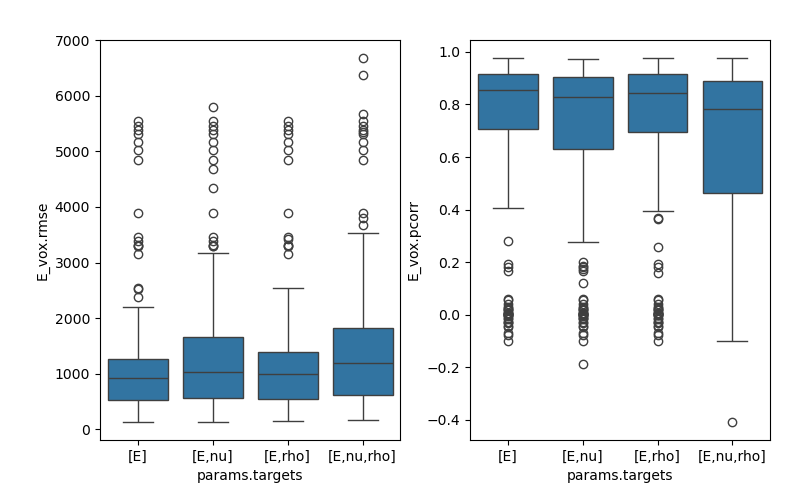

In [71]:
fig, axes = mpl_viz.subplot_grid(1, 2, ax_height=4, ax_width=3, padding=(1.0, 0.4, 0.6, 0.4), spacing=0.7) # lrbt

is_outlier = ex_df['E_vox.nrmse'] > 2
print(ex_df[is_outlier])

sns.boxplot(ex_df[~is_outlier], x='params.targets', y='E_vox.rmse', ax=axes[0,0])
sns.boxplot(ex_df[~is_outlier], x='params.targets', y='E_vox.pcorr', ax=axes[0,1])

2


<Axes: xlabel='params.targets', ylabel='E_vox.mean'>

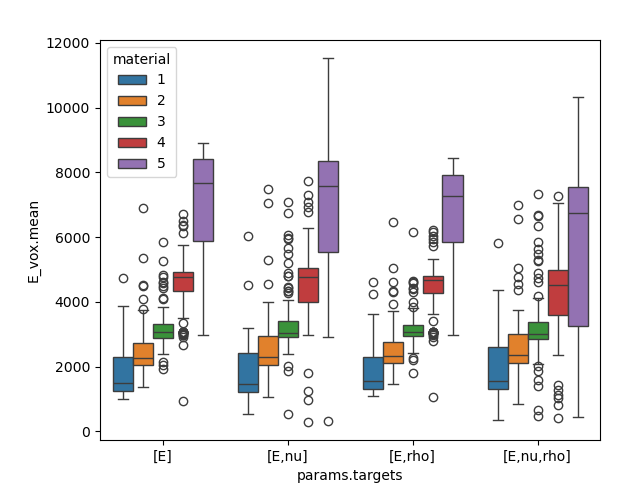

In [87]:
fig, axes = mpl_viz.subplot_grid(1, 1, ax_height=4, ax_width=5, padding=(1.0, 0.4, 0.6, 0.4), spacing=0.7) # lrbt

cmap = project.visual.matplotlib.get_label_cmap(5)

is_outlier = mat_df['E_vox.nrmse'] > 10
print(len(mat_df[is_outlier].shape))

sns.boxplot(mat_df[~is_outlier], x='params.targets', y='E_vox.mean', hue='material', palette=cmap, ax=axes[0,0])

<Axes: xlabel='Count', ylabel='E_cell.nrmse'>

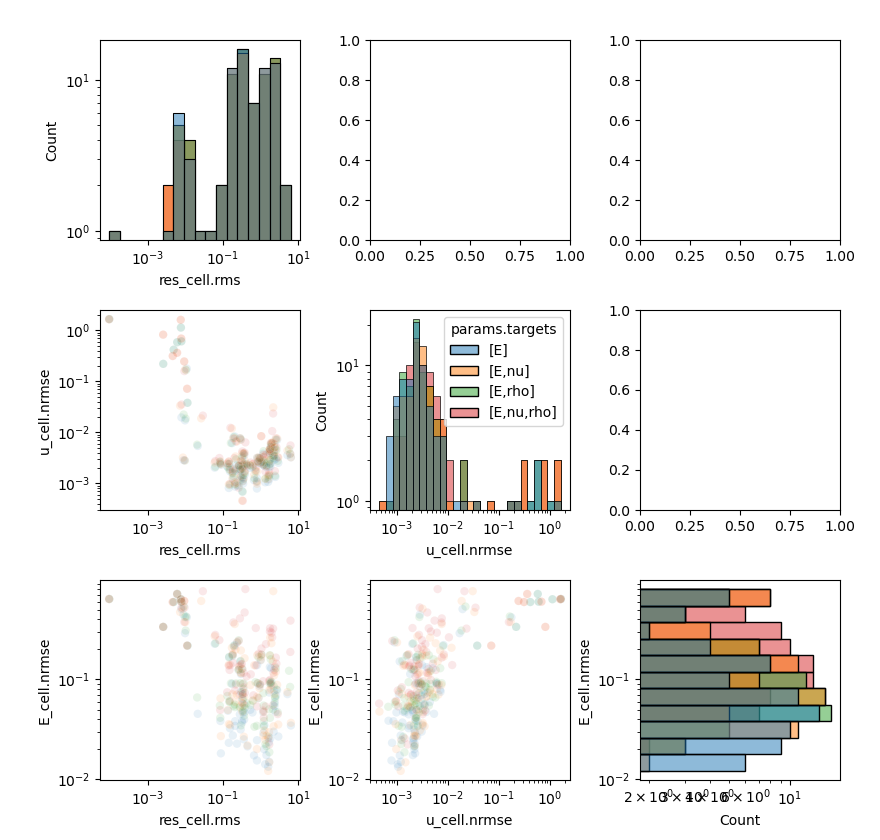

In [28]:
fig, axes = mpl_viz.subplot_grid(3, 3, ax_height=2, ax_width=2, padding=(1.0, 0.4, 0.6, 0.4), spacing=0.7) # lrbt

df = ex_df#[ex_df.subj_ok]
hue = 'params.targets'

ax = axes[0,0]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.histplot(df, x='res_cell.rms', hue=hue, legend=False, ax=ax)

ax = axes[1,0]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.scatterplot(df, x='res_cell.rms', y='u_cell.nrmse', hue=hue, legend=False, ax=ax, alpha=0.1)

ax = axes[2,0]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.scatterplot(df, x='res_cell.rms', y='E_cell.nrmse', hue=hue, legend=False, ax=ax, alpha=0.1)

ax = axes[1,1]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.histplot(df, x='u_cell.nrmse', hue=hue, legend=True, ax=ax)

ax = axes[2,1]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.scatterplot(df, x='u_cell.nrmse', y='E_cell.nrmse', hue=hue, legend=False, ax=ax, alpha=0.1)

ax = axes[2,2]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.histplot(df, y='E_cell.nrmse', hue=hue, legend=False, ax=ax)


In [33]:
ex_df.groupby(['params.rho_known'])[['res_cell.rms', 'u_cell.nrmse', 'E_cell.nrmse']].describe()

res_cell.rms                                           \
                        count      mean        std       min       25%   
params.rho_known                                                         
False                   942.0  3.329774  47.299533  0.000061  0.040692   
True                    945.0  3.568397  50.464712  0.000071  0.041516   

                                                  u_cell.nrmse            ...  \
                       50%       75%          max        count      mean  ...   
params.rho_known                                                          ...   
False             0.320063  1.901465  1141.623822        942.0  0.011809  ...   
True              0.325135  2.108678  1180.394943        945.0  0.001635  ...   

                                     E_cell.nrmse                      \
                       75%       max        count      mean       std   
params.rho_known                                                        
False             0.015404  0.060270        942.0  0.665301  1.480040   
True              0.002065  0.032045        945.0  0.166213  0.088445   

                                                                     
                       min       25%       50%       75%        max  
params.rho_known                                                     
False             0.112156  0.295780  0.372024  0.473036  28.378277  
True              0.013344  0.097247  0.155928  0.215861   0.544482  

[2 rows x 24 columns]

<Axes: xlabel='params.rho_known', ylabel='mat_vox.dice'>

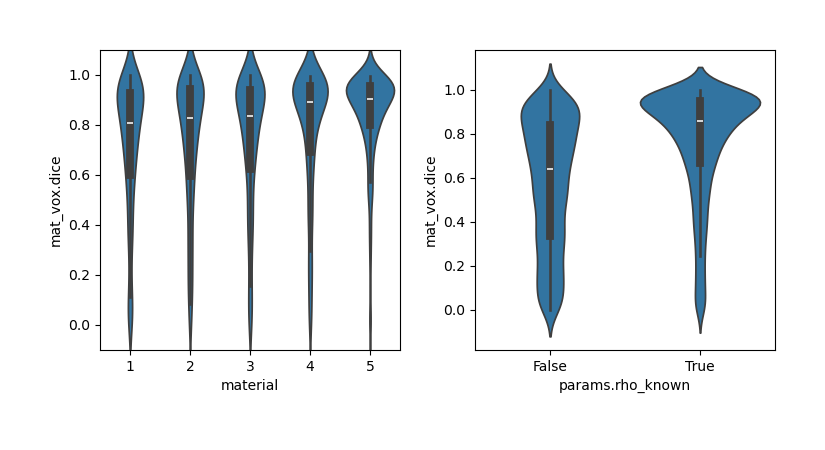

In [35]:
fig, axes = mpl_viz.subplot_grid(
    1, 2,
    ax_height=3,
    ax_width=3,
    padding=[1.0, 0.5, 1.0, 0.5], 
    spacing=[0.75, 0.75]
)

sns.violinplot(
    mat_df[
        (mat_df['params.rho_known'] == True)
    ],
    x='material',
    y='mat_vox.dice',
    ax=axes[0,0]
)
axes[0,0].set_ylim(-0.1, 1.1)

sns.violinplot(
    mat_df,
    x='params.rho_known',
    y='mat_vox.dice',
    ax=axes[0,1]
)

In [36]:
mat_df.groupby(['material'])['num_voxels'].sum()

material
1    159203158
2    158368364
3    145977058
4    152267354
5    154316727
Name: num_voxels, dtype: int64

In [38]:
mat_df

,epoch,phase,batch,step,loss,subject,material,num_voxels,E_vox.mean,E_vox.rms,...,res_cell.mean,res_cell.rms,source_path,job_name,job_id,params_hash,params.subject,params.rho_known,params.variant,params.config
0,0,optimize,0,0,0.000097,wss.100f39dce7690f59efb94709f30ce0d2,1,514631,1053.918143,1074.383569,...,0.443996,0.796575,/ocean/projects/asc170022p/mtragoza/lung-proje...,8cb03f00498ceb7e,37170031,8cb03f00498ceb7e,wss.100f39dce7690f59efb94709f30ce0d2,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
1,0,optimize,0,0,0.000097,wss.100f39dce7690f59efb94709f30ce0d2,3,263996,2866.401347,2885.555378,...,0.406966,0.798002,/ocean/projects/asc170022p/mtragoza/lung-proje...,8cb03f00498ceb7e,37170031,8cb03f00498ceb7e,wss.100f39dce7690f59efb94709f30ce0d2,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
2,0,optimize,0,0,0.001000,wss.100f39dce7690f59efb94709f30ce0d2,1,514631,2161.618482,21481.902769,...,0.441113,0.837417,/ocean/projects/asc170022p/mtragoza/lung-proje...,5063ce4526ce825f,37170032,5063ce4526ce825f,wss.100f39dce7690f59efb94709f30ce0d2,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
3,0,optimize,0,0,0.001000,wss.100f39dce7690f59efb94709f30ce0d2,3,263996,2963.689018,3023.212363,...,0.409144,0.846126,/ocean/projects/asc170022p/mtragoza/lung-proje...,5063ce4526ce825f,37170032,5063ce4526ce825f,wss.100f39dce7690f59efb94709f30ce0d2,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
4,0,optimize,0,0,0.000044,wss.101354f9d8dede686f7b08d9de913afe,1,22904,2571.847575,2850.644237,...,0.031527,0.073178,/ocean/projects/asc170022p/mtragoza/lung-proje...,b51e311be878d90f,37170033,b51e311be878d90f,wss.101354f9d8dede686f7b08d9de913afe,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,1,48216,1438.019681,1733.188208,...,0.002065,0.003122,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
5652,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,2,3701,2850.541585,3104.167744,...,0.001454,0.003063,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
5653,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,3,2355,3292.057367,3619.586094,...,0.002326,0.002896,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
5654,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,4,23375,3622.184732,3769.308774,...,0.002362,0.003472,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...


In [39]:
(mat_df.groupby(['subject'])['material'].nunique() == 1).sum()

np.int64(0)

In [40]:
mat_df['subject'].nunique()

945

In [41]:
one_material = (mat_df.groupby(['subject'])['material'].nunique() == 1)
one_material_subjs = one_material[one_material == True]

one_material_rows = mat_df[mat_df.subject.isin(one_material_subjs.index)]

for i in range(1, 6):
    n = len(one_material_rows[one_material_rows.material == i])
    print(i, n)

1 0
2 0
3 0
4 0
5 0


In [43]:
mat_df.groupby('material')[['E_cell.nrmse', 'mat_vox.dice']].describe()

E_cell.nrmse                                                        \
                count      mean       std           min       25%       50%   
material                                                                      
1              1145.0  1.405390  2.601865  5.493164e-07  0.502715  0.928029   
2              1151.0  0.491134  0.606760  2.929688e-06  0.220941  0.367777   
3              1135.0  0.357113  0.608319  4.069010e-06  0.161705  0.274919   
4              1084.0  0.362849  0.610067  1.534765e-03  0.132610  0.249741   
5              1139.0  0.289510  0.277605  9.765625e-07  0.166419  0.255829   

                              mat_vox.dice                                     \
               75%        max        count      mean       std  min       25%   
material                                                                        
1         1.537624  48.393378       1145.0  0.677310  0.278018  0.0  0.524507   
2         0.598953  13.404579       1151.0  0.631146  0.298892  0.0  0.398881   
3         0.402892  12.059772       1137.0  0.624095  0.302211  0.0  0.371065   
4         0.400166   8.546600       1084.0  0.666309  0.290749  0.0  0.455801   
5         0.363033   6.169853       1139.0  0.753455  0.250242  0.0  0.664733   

                                        
               50%       75%       max  
material                                
1         0.764607  0.900082  0.998683  
2         0.711946  0.896186  0.999385  
3         0.701345  0.893000  0.998024  
4         0.768438  0.918273  0.997689  
5         0.850059  0.938909  0.994033

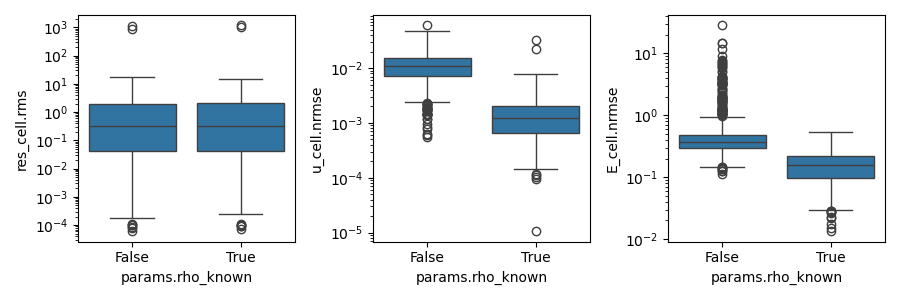

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))
plot_fn = sns.boxplot
for ax in axes:
    ax.set_yscale('log')
plot_fn(df, x='params.rho_known', y='res_cell.rms', ax=axes[0])
plot_fn(df, x='params.rho_known', y='u_cell.nrmse', ax=axes[1])
plot_fn(df, x='params.rho_known', y='E_cell.nrmse', ax=axes[2])
fig.tight_layout()